#                                 Classification of balls based on Commentary

#### Importing Required packages

In [1]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import resample

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


#### Loading the Datasets

In [2]:
# Read Train Data and store in a DataFrame
train_df = pd.read_excel("CCC_TrainingData.xlsx")

# Read Test Data and store in a DataFrame
test_df = pd.read_excel("CCC_TestData.xlsx")

train_df.head()

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target
0,0,803965640511,49.6,and india reach 300. there has been a 300 in ...,4,Run_Bw_Wickets
1,1,803965640511,49.5,"slower ball, ashwin bunts this to leg for -99...",4,Run_Bw_Wickets
2,2,803965640511,49.4,"full toss on off, he just slogs, gets a thick...",4,Run_Bw_Wickets
3,3,803965640511,49.3,that's the closest you'll get to a hat-trick ...,4,Dot
4,4,803965640511,49.2,sohail is doing the sajda after bowling rahan...,4,Wicket


#### Analyzing the given Dataset

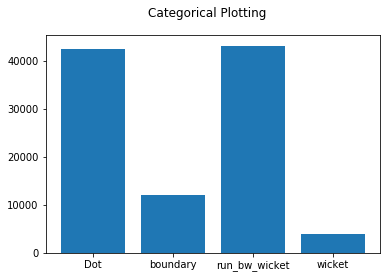

In [3]:
dot_count=len(train_df[train_df['Target']=='Dot']) #count of dot balls
wicket_count=len(train_df[train_df['Target']=='Wicket']) #count of wickets
boundary_count=len(train_df[train_df['Target']=='Boundary']) #count of boundaries
rbw_count=len(train_df[train_df['Target']=='Run_Bw_Wickets']) #count of run between wickets

data = {'Dot': dot_count, 'wicket': wicket_count, 'boundary':boundary_count, 'run_bw_wicket':rbw_count}
names = list(data.keys())
values = list(data.values())
plt.bar(names, values)  #bar graph for visualizing count of each class
plt.suptitle('Categorical Plotting')
plt.show()  

#### Balancing the dataset

In [4]:
#balancing the imbalanced data by oversampling the minority classes

df_wicket = train_df[train_df.Target=='Wicket']
df_boundary = train_df[train_df.Target=='Boundary']
df_rbw = train_df[train_df.Target=='Run_Bw_Wickets']
df_dot = train_df[train_df.Target=='Dot']
 
# Upsample minority class
wicket_sample = resample(df_wicket,replace=True,     # sample with replacement
                                 n_samples=30000,    # to match majority class
                                 random_state=123)   # reproducible results
boundary_sample = resample(df_boundary,replace=True, # sample with replacement
                                 n_samples=30000,    # to match majority class
                                 random_state=123)   # reproducible results
df = pd.concat([wicket_sample, boundary_sample,df_rbw,df_dot ],ignore_index=True)
df.head()

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target
0,91685,803968295711,1.4,simple catch at first slip and anamul succumb...,3,Wicket
1,89019,803968292911,19.1,russel slogs across the line and like so many...,21,Wicket
2,89340,803968293122,7.1,"and he strikes immediately, with a short of l...",4,Wicket
3,40043,8048113659222,11.4,run -999 at the non-striker's end! full and w...,10,Wicket
4,35744,8048108263322,7.5,this is easier than catching practice to axar...,2,Wicket


#### Analyzing balanced data

In [5]:
#summary of data after oversampling

print("No. of rows ",len(df))

matches=pd.Categorical(df['Match_ID'])
print("No. of matches ",len(matches.unique()))

categories=pd.Categorical(df['Target'])
print("Target classes: ",categories.unique())
for i in categories.unique():
    print("No.of {} balls {}".format(i,len(df[df['Target']==i])))

No. of rows  145607
No. of matches  775
Target classes:  [Wicket, Boundary, Run_Bw_Wickets, Dot]
Categories (4, object): [Wicket, Boundary, Run_Bw_Wickets, Dot]
No.of Wicket balls 30000
No.of Boundary balls 30000
No.of Run_Bw_Wickets balls 43085
No.of Dot balls 42522


#### Visualizing the class counts after balancing

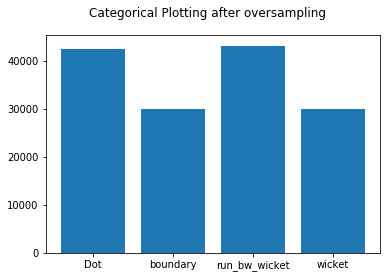

In [6]:
#visualization of classes

dot_count=len(df[df['Target']=='Dot'])
wicket_count=len(df[df['Target']=='Wicket'])
boundary_count=len(df[df['Target']=='Boundary'])
rbw_count=len(df[df['Target']=='Run_Bw_Wickets'])

data = {'Dot': dot_count, 'wicket': wicket_count, 'boundary':boundary_count, 'run_bw_wicket':rbw_count}
names = list(data.keys())
values = list(data.values())
plt.bar(names, values)
plt.suptitle('Categorical Plotting after oversampling')
plt.show()

#### Cleaning the data

In [7]:
#pre-processing the text in commentary 

nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
def clean_text(text):
    t=text.replace('-999','')
    text_nopunct = "".join([char for char in t if char not in string.punctuation])
    tokens = re.split('\s+', text_nopunct.strip())
    text_nosw=" ".join([word for word in tokens if word not in stopword])
    text_lemmatized =" ".join([wn.lemmatize(word) for word in text_nosw])
    return text_nosw

df['clean_text'] = df['Commentary'].apply(lambda x: clean_text(x))
df.head() 

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,ID,Match_ID,Over,Commentary,Over_Run_Total,Target,clean_text
0,91685,803968295711,1.4,simple catch at first slip and anamul succumb...,3,Wicket,simple catch first slip anamul succumbs rash s...
1,89019,803968292911,19.1,russel slogs across the line and like so many...,21,Wicket,russel slogs across line like many others mist...
2,89340,803968293122,7.1,"and he strikes immediately, with a short of l...",4,Wicket,strikes immediately short length ball movement...
3,40043,8048113659222,11.4,run -999 at the non-striker's end! full and w...,10,Wicket,run nonstrikers end full wide outside tripathi...
4,35744,8048108263322,7.5,this is easier than catching practice to axar...,2,Wicket,easier catching practice axar patel short cove...


#### Calculating length of clean text

In [8]:
df['length'] = df['clean_text'].apply(lambda x: len(x)) #finding length of the clean_text
df.head()
indexNames = df[df['length']== 0 ].index   #finding records having zero length
df.drop(indexNames, inplace=True)           # Removing records having length equal to 0 from dataframe


#### Visualizing the length Distribution

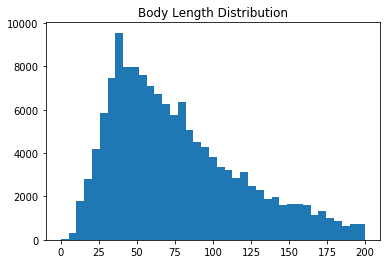

In [9]:
#visualisation of body length distribution

bins = np.linspace(0, 200, 40)
plt.hist(df['length'], bins)
plt.title("Body Length Distribution")
plt.show()

#### Creating Train and Test splits

In [10]:
#creating train and test split

X=df['clean_text']  
Y=df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#### Defining the Model 

In [12]:
#using machinelearning pipeline to vectorize the data and build model

model = Pipeline([('vect',CountVectorizer(ngram_range=(1,3))),  #vectorizing the data
              ('tfidf',TfidfTransformer()),                 #normalizing the vectorized data
              ('clf',svm.LinearSVC())])                  #defining the SupportVector model

model_desc = model.fit(X_train, y_train) #Training the model using train data

model_desc

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

#### Prediction on test split and calculating metrics

In [13]:
y_pred=model.predict(X_test) #making predictions on test-split using model

precision, recall, fscore, support = score(y_test, y_pred) #calculating metrics

print("FScore:",fscore) #printing the fscore

print("Accuracy is ",accuracy_score(y_pred,y_test)) #calculate and print the accuracy

FScore: [0.92407393 0.83127182 0.80014718 0.96352462]
Accuracy is  0.8709300728121995


#### Prediction on Test data

In [14]:
# Make predictions on the test data

test_df['clean_text']=test_df['Commentary'].apply(lambda x: clean_text(x)) #cleaning the test data before prediction
predictions = model.predict(test_df['clean_text'])   #predicting using the model
predictions

array(['Boundary', 'Dot', 'Dot', ..., 'Run_Bw_Wickets', 'Run_Bw_Wickets',
       'Boundary'], dtype=object)

#### Generating the output file

In [15]:
#Preparing Submission File
submission = pd.DataFrame({'ID': test_df["ID"], 'Target': predictions})

# Write the submission data frame to a file
submission.to_excel("submission2.xlsx",index=False)